## Required Imports

In [1503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [1504]:
nfl_teams = {
    "Cardinals": "ARI",
    "Falcons": "ATL",
    "Ravens": "BAL",
    "Bills": "BUF",
    "Panthers": "CAR",
    "Bears": "CHI",
    "Bengals": "CIN",
    "Browns": "CLE",
    "Cowboys": "DAL",
    "Broncos": "DEN",
    "Lions": "DET",
    "Packers": "GB",
    "Texans": "HOU",
    "Colts": "IND",
    "Jaguars": "JAX",
    "Chiefs": "KC",
    "Raiders": "OAK",
    "Chargers": "LAC",
    "Rams": "LA",
    "Dolphins": "MIA",
    "Vikings": "MIN",
    "Patriots": "NE",
    "Saints": "NO",
    "Giants": "NYG",
    "Jets": "NYJ",
    "Eagles": "PHI",
    "Steelers": "PIT",
    "49ers": "SF",
    "Seahawks": "SEA",
    "Buccaneers": "TB",
    "Titans": "TEN",
    "Redskins": "WAS"
}


In [1505]:
raw_team_data = pd.read_csv("data/madden_ratings.csv",header=0,low_memory=False)
print(raw_team_data.shape)
raw_team_data.head()

(2342, 53)


,Last Name,First Name,Team,Position,Overall,Speed,Acceleration,Strength,Agility,Awareness,...,Catch In Traffic,Route Running,Hit Power,Press,Release,Throw Accuracy Short,Throw Accuracy Mid,Throw Accuracy Deep,Play Action,Throw on the Run
0,Thompson,Chris,Redskins,HB,77,91,94,63,91,77,...,60,60,12,20,54,35,30,20,15,15
1,Allen,Keenan,Chargers,WR,89,89,92,69,91,90,...,94,94,15,10,89,30,25,15,15,25
2,McFadden,Darren,Cowboys,HB,77,89,89,72,82,80,...,66,75,15,15,66,51,45,20,20,40
3,Boykin,Brandon,Ravens,CB,71,89,93,52,87,64,...,35,40,56,65,40,6,6,6,6,6
4,Galette,Junior,Redskins,LOLB,76,77,84,75,78,76,...,15,15,82,35,15,6,6,6,6,6


In [1506]:
raw_team_data['Team'] = raw_team_data['Team'].apply(lambda x: nfl_teams[x])
raw_team_data = raw_team_data[['Team', 'Position','Overall']]
raw_team_data.head()

,Team,Position,Overall
0,WAS,HB,77
1,LAC,WR,89
2,DAL,HB,77
3,BAL,CB,71
4,WAS,LOLB,76


In [1507]:
position_counts = {
    'QB':1,
    'HB':1,
    'WR':2,
    'TE':1,
    'LT':1,
    'LG':1,
    'C':1,
    'RG':1,
    'RT':1,
    'LE':1,
    'RE':1,
    'DT':2,
    'LOLB':1,
    'MLB':1,
    'ROLB':1,
    'CB':3,
    'FS':1,
    'SS':1,
}

position_groups = {
    'Quarterback': ['QB'],
    'Running_back': ['HB'],
    'Recievers': ['WR', 'TE'],
    'Oline': ['LT', 'LG', 'C', 'RG', 'RT'],
    'Left_Oline': ['LT', 'LG'],
    'Right_Oline': ['RT', 'RG'],
    'Run_Defense': ['LE', 'DT', 'RE', 'MLB', 'LOLB', 'ROLB'],
    'Left_Run_Defense': ['LE','LOLB'],
    'Right_Run_Defense': ['RE','ROLB'],
    'Pass_Defense': ['CB', 'FS', 'SS']
}

In [1508]:
cols = ['Team'] + list(position_counts.keys()) + list(position_groups.keys())
madden_data = pd.DataFrame(np.nan, columns=cols, index=range(0,32))
madden_data['Team'] = nfl_teams.values()
madden_data.head()


,Team,QB,HB,WR,TE,LT,LG,C,RG,RT,...,Quarterback,Running_back,Recievers,Oline,Left_Oline,Right_Oline,Run_Defense,Left_Run_Defense,Right_Run_Defense,Pass_Defense
0,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BUF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1509]:
for pos in list(position_counts.keys()):
    pos_df = raw_team_data[raw_team_data['Position'] == pos]
    pos_sorted = pos_df.sort_values(['Team', 'Overall'], ascending=[True, False])
    top_n_pos = pos_sorted.groupby('Team').head(position_counts[pos])
    avg_top_n_pos = top_n_pos.groupby('Team')['Overall'].mean().reset_index()
    average_dict = dict(zip(avg_top_n_pos['Team'], avg_top_n_pos['Overall']))
    madden_data[pos] = madden_data['Team'].map(average_dict)
madden_data.head()

,Team,QB,HB,WR,TE,LT,LG,C,RG,RT,...,Quarterback,Running_back,Recievers,Oline,Left_Oline,Right_Oline,Run_Defense,Left_Run_Defense,Right_Run_Defense,Pass_Defense
0,ARI,83.0,94.0,87.0,77.0,71.0,77.0,80.0,71.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATL,96.0,89.0,90.0,77.0,77.0,84.0,91.0,64.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAL,81.0,82.0,82.5,80.0,80.0,71.0,72.0,96.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BUF,82.0,92.0,81.5,86.0,84.0,88.0,73.0,76.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAR,88.0,84.0,80.5,92.0,78.0,84.0,81.0,77.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1510]:
for group in list(position_groups.keys()):
    madden_data[group] = madden_data[position_groups[group]].mean(axis=1)
madden_data.head()

,Team,QB,HB,WR,TE,LT,LG,C,RG,RT,...,Quarterback,Running_back,Recievers,Oline,Left_Oline,Right_Oline,Run_Defense,Left_Run_Defense,Right_Run_Defense,Pass_Defense
0,ARI,83.0,94.0,87.0,77.0,71.0,77.0,80.0,71.0,84.0,...,83.0,94.0,82.00,76.6,74.0,77.5,77.500000,79.0,80.0,80.444444
1,ATL,96.0,89.0,90.0,77.0,77.0,84.0,91.0,64.0,87.0,...,96.0,89.0,83.50,80.6,80.5,75.5,78.250000,80.0,74.0,82.222222
2,BAL,81.0,82.0,82.5,80.0,80.0,71.0,72.0,96.0,69.0,...,81.0,82.0,81.25,77.6,75.5,82.5,77.916667,71.5,77.5,87.555556
3,BUF,82.0,92.0,81.5,86.0,84.0,88.0,73.0,76.0,76.0,...,82.0,92.0,83.75,79.4,86.0,76.0,80.000000,77.5,82.5,74.444444
4,CAR,88.0,84.0,80.5,92.0,78.0,84.0,81.0,77.0,74.0,...,88.0,84.0,86.25,78.8,81.0,75.5,85.916667,83.0,85.0,79.111111


In [1511]:
full_team_names = {
    "Arizona Cardinals": "ARI",
    "Atlanta Falcons": "ATL",
    "Baltimore Ravens": "BAL",
    "Buffalo Bills": "BUF",
    "Carolina Panthers": "CAR",
    "Chicago Bears": "CHI",
    "Cincinnati Bengals": "CIN",
    "Cleveland Browns": "CLE",
    "Dallas Cowboys": "DAL",
    "Denver Broncos": "DEN",
    "Detroit Lions": "DET",
    "Green Bay Packers": "GB",
    "Houston Texans": "HOU",
    "Indianapolis Colts": "IND",
    "Jacksonville Jaguars": "JAX",
    "Kansas City Chiefs": "KC",
    "Los Angeles Rams": "LA",
    "Los Angeles Chargers": "LAC",
    "Miami Dolphins": "MIA",
    "Minnesota Vikings": "MIN",
    "New England Patriots": "NE",
    "New Orleans Saints": "NO",
    "New York Giants": "NYG",
    "New York Jets": "NYJ",
    "Oakland Raiders": "OAK",  # Raiders were in Oakland in 2018
    "Philadelphia Eagles": "PHI",
    "Pittsburgh Steelers": "PIT",
    "San Francisco 49ers": "SF",
    "Seattle Seahawks": "SEA",
    "Tampa Bay Buccaneers": "TB",
    "Tennessee Titans": "TEN",
    "Washington Redskins": "WAS"  # Official name in 2018
}


In [1512]:
raw_season_data = pd.read_csv("data/team_stats.csv",header=0,low_memory=False)
print(raw_season_data.shape)
raw_season_data.head()

(672, 35)


,year,team,wins,losses,win_loss_perc,points,points_opp,points_diff,mov,g,...,rush_td,rush_yds_per_att,rush_fd,penalties,penalties_yds,pen_fd,score_pct,turnover_pct,exp_pts_tot,ties
0,2003,New England Patriots,14,2,0.875,348,238,110,6.9,16,...,9,3.4,91,111,998,26,27.9,11.3,-136.51,NaN
1,2003,Miami Dolphins,10,6,0.625,311,261,50,3.1,16,...,14,3.7,99,103,913,22,28.1,17.2,-177.92,NaN
2,2003,Buffalo Bills,6,10,0.375,243,279,-36,-2.3,16,...,13,3.9,96,106,891,22,21.9,17.6,-230.07,NaN
3,2003,New York Jets,6,10,0.375,283,299,-16,-1.0,16,...,8,4.0,78,69,550,15,32.4,11.8,-107.89,NaN
4,2003,Baltimore Ravens,10,6,0.625,391,281,110,6.9,16,...,18,4.8,115,126,970,23,31.8,16.6,-220.50,NaN


In [1513]:
team_data = raw_season_data[raw_season_data['year'] == 2017]
team_data['team'] = team_data.apply(lambda x: full_team_names[x['team']], axis=1)
team_data.drop(columns=['ties'], inplace=True)
team_data.head()

/var/folders/x3/q9hsrj516xsbqf99gftzt4vr0000gn/T/ipykernel_76836/3545099961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data['team'] = team_data.apply(lambda x: full_team_names[x['team']], axis=1)
/var/folders/x3/q9hsrj516xsbqf99gftzt4vr0000gn/T/ipykernel_76836/3545099961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data.drop(columns=['ties'], inplace=True)


,year,team,wins,losses,win_loss_perc,points,points_opp,points_diff,mov,g,...,rush_yds,rush_td,rush_yds_per_att,rush_fd,penalties,penalties_yds,pen_fd,score_pct,turnover_pct,exp_pts_tot
448,2017,NE,13,3,0.813,458,296,162,10.1,16,...,1889,16,4.2,107,95,835,50,49.4,6.9,114.84
449,2017,BUF,9,7,0.563,302,359,-57,-3.6,16,...,2017,12,4.1,105,98,872,24,31.7,8.9,-156.16
450,2017,MIA,6,10,0.375,281,393,-112,-7.0,16,...,1388,4,3.9,66,137,1154,31,25.8,15.3,-156.17
451,2017,NYJ,5,11,0.313,298,382,-84,-5.3,16,...,1702,13,4.0,77,119,1035,35,28.6,11.1,-119.83
452,2017,PIT,13,3,0.813,406,308,98,6.1,16,...,1667,12,3.8,96,101,897,35,43.0,10.6,-32.55


In [1514]:
data2018 = pd.read_csv("data/pbp-2018.csv")
data2018 = data2018[data2018['IsNoPlay'] == 0]
data2018 = data2018[data2018['Down'] != 0]
data2018 = data2018[data2018['PlayType'] != pd.NA]
data2018["game_seconds_left"] = ((4 - data2018['Quarter']) * 60 * 15) + ((data2018['Minute']) * 60) + data2018['Second']
data2018["playid"] = data2018['GameId'].astype(str).str[:-2] + data2018["game_seconds_left"].astype(str) + data2018['OffenseTeam']
print(data2018.shape)
data2018.head()

(35133, 47)


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,game_seconds_left,playid
1,2018120913,2018-12-09,2,0,14,PIT,LV,3,1,99,...,NaN,1,OPP,0,NaN,0,NaN,0,1814,201812091814PIT
2,2018120913,2018-12-09,2,0,25,PIT,LV,2,2,98,...,NaN,2,OPP,0,NaN,0,NaN,0,1825,201812091825PIT
3,2018120913,2018-12-09,2,0,33,PIT,LV,1,2,98,...,CENTER,2,OPP,0,NaN,0,NaN,0,1833,201812091833PIT
4,2018120913,2018-12-09,2,1,15,PIT,LV,3,9,88,...,NaN,12,OPP,0,NaN,0,NaN,0,1875,201812091875PIT
5,2018120913,2018-12-09,2,1,20,PIT,LV,2,9,88,...,NaN,12,OPP,0,NaN,0,NaN,0,1880,201812091880PIT


In [1515]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data2018):
    # Drop columns: 'GameId', 'GameDate' and 28 other columns
    data2018 = data2018.drop(columns=['GameId', 'GameDate', 'Unnamed: 10', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin', 'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown', 'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed', 'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble', 'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful', 'IsPenaltyAccepted', 'PenaltyTeam', 'PenaltyType', 'PenaltyYards'])
    return data2018

data2018_clean = clean_data(data2018.copy())
data2018_clean.head()

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Formation,PlayType,RushDirection,YardLineFixed,YardLineDirection,IsNoPlay,game_seconds_left,playid
1,2,0,14,PIT,LV,3,1,99,1,SHOTGUN,PASS,NaN,1,OPP,0,1814,201812091814PIT
2,2,0,25,PIT,LV,2,2,98,0,SHOTGUN,PASS,NaN,2,OPP,0,1825,201812091825PIT
3,2,0,33,PIT,LV,1,2,98,0,SHOTGUN,RUSH,CENTER,2,OPP,0,1833,201812091833PIT
4,2,1,15,PIT,LV,3,9,88,1,SHOTGUN,PASS,NaN,12,OPP,0,1875,201812091875PIT
5,2,1,20,PIT,LV,2,9,88,0,SHOTGUN,PASS,NaN,12,OPP,0,1880,201812091880PIT


In [1516]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data2018_clean):
    # Drop rows with missing data in column: 'PlayType'
    data2018_clean = data2018_clean.dropna(subset=['PlayType'])
    return data2018_clean

data2018_clean_1 = clean_data(data2018_clean.copy())
data2018_clean_1.head()

data2018 = data2018_clean_1
print(data2018.shape)
data2018.head()

(35107, 17)


,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Formation,PlayType,RushDirection,YardLineFixed,YardLineDirection,IsNoPlay,game_seconds_left,playid
1,2,0,14,PIT,LV,3,1,99,1,SHOTGUN,PASS,NaN,1,OPP,0,1814,201812091814PIT
2,2,0,25,PIT,LV,2,2,98,0,SHOTGUN,PASS,NaN,2,OPP,0,1825,201812091825PIT
3,2,0,33,PIT,LV,1,2,98,0,SHOTGUN,RUSH,CENTER,2,OPP,0,1833,201812091833PIT
4,2,1,15,PIT,LV,3,9,88,1,SHOTGUN,PASS,NaN,12,OPP,0,1875,201812091875PIT
5,2,1,20,PIT,LV,2,9,88,0,SHOTGUN,PASS,NaN,12,OPP,0,1880,201812091880PIT


In [1517]:
raw_data = pd.read_csv("data/NFL_Play_by_Play_2009_2018.csv", header=0,low_memory=False)
print(raw_data.shape)
raw_data.head()

(449371, 255)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


## Data loaded

In [1653]:
data = raw_data

In [1654]:
data['year'] = data['game_date'].apply(lambda x: int(x.split('-')[0]))
data['month'] = data['game_date'].apply(lambda x: int(x.split('-')[1]))
data['year_adjusted'] = data.apply(lambda x: x['year'] - 1 if x['month'] < 9 else x['year'], axis=1)
data.head()


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,year,month,year_adjusted
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,9,2009
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,9,2009
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,9,2009
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,9,2009
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,9,2009


In [1655]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data):
    # Drop columns: 'game_id', 'posteam_type' and 223 other columns
    data = data.drop(columns=['rush_attempt', 'pass_attempt', 'posteam_type', 'game_date', 'yrdln', 'desc', 'yards_gained', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout_team', 'timeout', 'td_team', 'total_home_score', 'total_away_score', 'posteam_score_post', 'defteam_score_post', 'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'home_wp_post', 'away_wp_post', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 'air_wpa', 'comp_air_wpa', 'yac_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa', 'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'punt_inside_twenty', 'punt_in_endzone', 'punt_downed', 'punt_out_of_bounds', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'fumble_forced', 'fumble_not_forced', 'solo_tackle', 'fumble_out_of_bounds', 'safety', 'penalty', 'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'complete_pass', 'fumble', 'assist_tackle', 'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 'passer_player_id', 'receiver_player_id', 'passer_player_name', 'receiver_player_name', 'rusher_player_id', 'lateral_receiver_player_name', 'lateral_receiver_player_id', 'rusher_player_name', 'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_sack_player_id', 'lateral_sack_player_name', 'interception_player_id', 'interception_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 'punt_returner_player_id', 'punt_returner_player_name', 'lateral_punt_returner_player_id', 'lateral_punt_returner_player_name', 'kickoff_returner_player_name', 'kickoff_returner_player_id', 'lateral_kickoff_returner_player_id', 'lateral_kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 'kicker_player_name', 'kicker_player_id', 'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name', 'blocked_player_id', 'blocked_player_name', 'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name', 'tackle_for_loss_2_player_id', 'tackle_for_loss_2_player_name', 'qb_hit_1_player_id', 'qb_hit_1_player_name', 'qb_hit_2_player_id', 'qb_hit_2_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_1_player_id', 'forced_fumble_player_1_player_name', 'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id', 'forced_fumble_player_2_player_name', 'solo_tackle_2_team', 'solo_tackle_1_player_id', 'solo_tackle_1_team', 'solo_tackle_2_player_id', 'solo_tackle_1_player_name', 'solo_tackle_2_player_name', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 'assist_tackle_1_team', 'assist_tackle_2_player_name', 'assist_tackle_2_player_id', 'assist_tackle_2_team', 'assist_tackle_3_player_name', 'assist_tackle_3_player_id', 'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 'assist_tackle_4_team', 'pass_defense_1_player_id', 'pass_defense_1_player_name', 'pass_defense_2_player_id', 'pass_defense_2_player_name', 'fumbled_1_team', 'fumbled_1_player_id', 'fumbled_1_player_name', 'fumbled_2_player_id', 'fumbled_2_player_name', 'fumbled_2_team', 'fumble_recovery_1_yards', 'fumble_recovery_1_team', 'fumble_recovery_1_player_id', 'fumble_recovery_1_player_name', 'fumble_recovery_2_team', 'fumble_recovery_2_yards', 'fumble_recovery_2_player_id', 'return_team', 'fumble_recovery_2_player_name', 'return_yards', 'penalty_team', 'penalty_player_id', 'penalty_player_name', 'penalty_yards', 'replay_or_challenge', 'replay_or_challenge_result', 'penalty_type', 'defensive_two_point_attempt', 'defensive_two_point_conv', 'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'year', 'month'])
    return data

data_clean = clean_data(data.copy())
data_clean.head()
data = data_clean

In [1656]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data):
    # Drop duplicate rows across all columns
    print(data)
    data = data[data["year_adjusted"] == 2018]
    data = data.drop_duplicates()
    return data

data_clean = clean_data(data.copy())
data_clean.head()

        play_id     game_id home_team away_team posteam defteam side_of_field  \
0            46  2009091000       PIT       TEN     PIT     TEN           TEN   
1            68  2009091000       PIT       TEN     PIT     TEN           PIT   
2            92  2009091000       PIT       TEN     PIT     TEN           PIT   
3           113  2009091000       PIT       TEN     PIT     TEN           PIT   
4           139  2009091000       PIT       TEN     PIT     TEN           PIT   
...         ...         ...       ...       ...     ...     ...           ...   
449366     4059  2018121700       CAR        NO     CAR      NO           CAR   
449367     4081  2018121700       CAR        NO     CAR      NO           CAR   
449368     4106  2018121700       CAR        NO     CAR      NO           CAR   
449369     4128  2018121700       CAR        NO      NO     CAR           CAR   
449370     4150  2018121700       CAR        NO     NaN     NaN           CAR   

        yardline_100  quart

,play_id,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,shotgun,no_huddle,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,year_adjusted
407335,37,2018090600,PHI,ATL,ATL,PHI,PHI,35.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,2018
407336,52,2018090600,PHI,ATL,ATL,PHI,ATL,75.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018
407337,75,2018090600,PHI,ATL,ATL,PHI,ATL,80.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018
407338,104,2018090600,PHI,ATL,ATL,PHI,ATL,70.0,862.0,1762.0,...,0,0,left,end,3.0,3.0,0.0,0.0,0.0,2018
407339,125,2018090600,PHI,ATL,ATL,PHI,ATL,59.0,826.0,1726.0,...,0,0,right,end,3.0,3.0,0.0,0.0,0.0,2018


## Cleaning

In [1657]:
data = data_clean
data = data.dropna(subset=['game_seconds_remaining'])
data.head()

,play_id,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,shotgun,no_huddle,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,year_adjusted
407335,37,2018090600,PHI,ATL,ATL,PHI,PHI,35.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,2018
407336,52,2018090600,PHI,ATL,ATL,PHI,ATL,75.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018
407337,75,2018090600,PHI,ATL,ATL,PHI,ATL,80.0,900.0,1800.0,...,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018
407338,104,2018090600,PHI,ATL,ATL,PHI,ATL,70.0,862.0,1762.0,...,0,0,left,end,3.0,3.0,0.0,0.0,0.0,2018
407339,125,2018090600,PHI,ATL,ATL,PHI,ATL,59.0,826.0,1726.0,...,0,0,right,end,3.0,3.0,0.0,0.0,0.0,2018


In [1658]:
data['playid'] = data['game_id'].astype(str).str[:-2] + data['game_seconds_remaining'].astype(int).astype(str) + data['posteam']
data.head()

/var/folders/x3/q9hsrj516xsbqf99gftzt4vr0000gn/T/ipykernel_76836/3045242571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['playid'] = data['game_id'].astype(str).str[:-2] + data['game_seconds_remaining'].astype(int).astype(str) + data['posteam']


,play_id,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,no_huddle,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,year_adjusted,playid
407335,37,2018090600,PHI,ATL,ATL,PHI,PHI,35.0,900.0,1800.0,...,0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,2018,201809063600ATL
407336,52,2018090600,PHI,ATL,ATL,PHI,ATL,75.0,900.0,1800.0,...,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018,201809063600ATL
407337,75,2018090600,PHI,ATL,ATL,PHI,ATL,80.0,900.0,1800.0,...,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018,201809063600ATL
407338,104,2018090600,PHI,ATL,ATL,PHI,ATL,70.0,862.0,1762.0,...,0,left,end,3.0,3.0,0.0,0.0,0.0,2018,201809063562ATL
407339,125,2018090600,PHI,ATL,ATL,PHI,ATL,59.0,826.0,1726.0,...,0,right,end,3.0,3.0,0.0,0.0,0.0,2018,201809063526ATL


In [1659]:
data.dropna(subset=['down', 'posteam'], inplace=True)
data = data[data['play_type'] != "no_play"]
data['run_gap'] = data.apply(lambda x: 'center' if x['run_location'] == 'middle' else x['run_gap'], axis=1)
data['offense_at_home'] = data.apply(lambda x: x['posteam'] == x['home_team'], axis=1)
data['game_half'] = data.apply(lambda x: 3 if x['game_half'] == 'Overtime' else int(x['game_half'][-1]), axis=1)
# data = data[data['play_type'].isin(['run'])]
data.head()


/var/folders/x3/q9hsrj516xsbqf99gftzt4vr0000gn/T/ipykernel_76836/826666426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['down', 'posteam'], inplace=True)


,play_id,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,year_adjusted,playid,offense_at_home
407337,75,2018090600,PHI,ATL,ATL,PHI,ATL,80.0,900.0,1800.0,...,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018,201809063600ATL,False
407338,104,2018090600,PHI,ATL,ATL,PHI,ATL,70.0,862.0,1762.0,...,left,end,3.0,3.0,0.0,0.0,0.0,2018,201809063562ATL,False
407339,125,2018090600,PHI,ATL,ATL,PHI,ATL,59.0,826.0,1726.0,...,right,end,3.0,3.0,0.0,0.0,0.0,2018,201809063526ATL,False
407340,146,2018090600,PHI,ATL,ATL,PHI,PHI,39.0,790.0,1690.0,...,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018,201809063490ATL,False
407341,168,2018090600,PHI,ATL,ATL,PHI,PHI,39.0,785.0,1685.0,...,NaN,NaN,3.0,3.0,0.0,0.0,0.0,2018,201809063485ATL,False


In [1660]:
offense_columns = ["Team", "QB", "HB", "WR", "TE", "LT", "LG", "C", "RG", "RT", "Quarterback", "Running_back", "Recievers", "Oline", "Left_Oline", "Right_Oline"]
defense_columns = ["Team", "LE", "DT", "RE", "LOLB", "MLB", "ROLB", "CB", "FS", "SS", "Run_Defense", "Left_Run_Defense", "Right_Run_Defense", "Pass_Defense"]
# offense_columns = ["Team", "QB", "HB", "WR", "TE", "LT", "LG", "C", "RG", "RT"]
# defense_columns = ["Team", "LE", "DT", "RE", "LOLB", "MLB", "ROLB", "CB", "FS", "SS"]

selected_columns = madden_data[offense_columns]
data = data.merge(selected_columns, left_on='posteam', right_on='Team', how='left')
data.drop('Team', axis=1, inplace=True)

selected_columns = madden_data[defense_columns]
data = data.merge(selected_columns, left_on='defteam', right_on='Team', how='left')
data.drop('Team', axis=1, inplace=True)

In [1661]:
offense_columns = ["team", "win_loss_perc", "points", "turnovers", "fumbles_lost", "pass_att", "pass_yds", "pass_td", "pass_int", "rush_att", "rush_yds", "rush_td"]

selected_columns = team_data[offense_columns]
data = data.merge(selected_columns, left_on='posteam', right_on='team', how='left')
data.drop('team', axis=1, inplace=True)
data.head()

,play_id,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,points,turnovers,fumbles_lost,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_td
0,75,2018090600,PHI,ATL,ATL,PHI,ATL,80.0,900.0,1800.0,...,353,18,6,530,3990,21,12,430,1847,12
1,104,2018090600,PHI,ATL,ATL,PHI,ATL,70.0,862.0,1762.0,...,353,18,6,530,3990,21,12,430,1847,12
2,125,2018090600,PHI,ATL,ATL,PHI,ATL,59.0,826.0,1726.0,...,353,18,6,530,3990,21,12,430,1847,12
3,146,2018090600,PHI,ATL,ATL,PHI,PHI,39.0,790.0,1690.0,...,353,18,6,530,3990,21,12,430,1847,12
4,168,2018090600,PHI,ATL,ATL,PHI,PHI,39.0,785.0,1685.0,...,353,18,6,530,3990,21,12,430,1847,12


In [1662]:
# formationData = ["playid", 'Formation']

# selected_columns = data2018[formationData]
# data = data.merge(selected_columns, left_on='playid', right_on='playid', how='left')
# data.drop('playid', axis=1, inplace=True)

In [1663]:
data['play_summary'] = data.apply(lambda x: str(x['play_type']), axis=1)
# data['play_summary'] = data.apply(lambda x: str(x['play_type']) + '_' + str(x['run_location']) if x['play_type'] == 'run' else str(str(x['play_type'])), axis=1)
data['half_seconds_remaining'].fillna(0, inplace=True)
data.drop(columns=["play_id","run_location", "run_gap", "play_type", "year_adjusted", "quarter_end", "side_of_field", "home_team", "away_team", "time", 'posteam', 'defteam', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining','playid', 'sp', 'ydsnet', 'posteam_score', 'defteam_score'], inplace=True)
data.head()

/var/folders/x3/q9hsrj516xsbqf99gftzt4vr0000gn/T/ipykernel_76836/198302261.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['half_seconds_remaining'].fillna(0, inplace=True)


,game_id,yardline_100,game_half,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,...,turnovers,fumbles_lost,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_td,play_summary
0,2018090600,80.0,1,1,1,1.0,0.0,15,0,0,...,18,6,530,3990,21,12,430,1847,12,pass
1,2018090600,70.0,1,1,1,2.0,0.0,5,0,0,...,18,6,530,3990,21,12,430,1847,12,run
2,2018090600,59.0,1,1,1,1.0,0.0,10,0,0,...,18,6,530,3990,21,12,430,1847,12,run
3,2018090600,39.0,1,1,1,1.0,0.0,10,0,0,...,18,6,530,3990,21,12,430,1847,12,pass
4,2018090600,39.0,1,1,1,2.0,0.0,10,1,0,...,18,6,530,3990,21,12,430,1847,12,pass


In [1664]:
print(data.shape)
data.head()

(30955, 54)


,game_id,yardline_100,game_half,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,...,turnovers,fumbles_lost,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_td,play_summary
0,2018090600,80.0,1,1,1,1.0,0.0,15,0,0,...,18,6,530,3990,21,12,430,1847,12,pass
1,2018090600,70.0,1,1,1,2.0,0.0,5,0,0,...,18,6,530,3990,21,12,430,1847,12,run
2,2018090600,59.0,1,1,1,1.0,0.0,10,0,0,...,18,6,530,3990,21,12,430,1847,12,run
3,2018090600,39.0,1,1,1,1.0,0.0,10,0,0,...,18,6,530,3990,21,12,430,1847,12,pass
4,2018090600,39.0,1,1,1,2.0,0.0,10,1,0,...,18,6,530,3990,21,12,430,1847,12,pass


In [1665]:
# # """
# # Cell generated by Data Wrangler.
# # """
# # def clean_data(data):
# #     # Drop rows with missing data in column: 'Formation'
# #     data = data.dropna(subset=['Formation'])
# #     return data

# # data_clean = clean_data(data.copy())
# # data_clean.head()

# for index, row in data.iterrows():
#     if pd.isna(row['Formation']):
#         print("HI")
#         if row['play_summary'] == "field_goal":
#             data.at[index, 'Formation'] = 'FIELD GOAL'
#         elif row['play_summary'] == "punt":
#             data.at[index, 'Formation'] = 'PUNT'
#         elif row['shotgun'] == 1:
#             data.at[index, 'Formation'] = 'SHOTGUN'
#         else:
#             data.at[index, 'Formation'] = 'UNDER CENTER'
#     elif row['Formation'] == "NO HUDDLE":
#         if row['shotgun'] == 1:
#             data.at[index, 'Formation'] = 'SHOTGUN'
#         else:
#             data.at[index, 'Formation'] = 'UNDER CENTER'


#     # # Concatenate 'First_Name' and 'Age', take the first 8 characters
#     # colValue = (row['First_Name'] + ' - Age: ' + str(row['Age']))[:8]
    
#     # # Assign the sliced string to the 'Info_Short' column
#     # data.at[index, 'Info_Short'] = info_value
# print("PAST")
# data['Formation'] = data.apply(lambda x: 'SHOTGUN' if x['Formation'] == "NO HUDDLE SHOTGUN" else x['Formation'], axis=1)
# data.head()


In [1666]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data):
    data = data.drop(columns=['game_id'])
    return data

data_clean = clean_data(data.copy())
data_clean.head()

data = data_clean
data.head()

,yardline_100,game_half,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,...,turnovers,fumbles_lost,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_td,play_summary
0,80.0,1,1,1,1.0,0.0,15,0,0,3.0,...,18,6,530,3990,21,12,430,1847,12,pass
1,70.0,1,1,1,2.0,0.0,5,0,0,3.0,...,18,6,530,3990,21,12,430,1847,12,run
2,59.0,1,1,1,1.0,0.0,10,0,0,3.0,...,18,6,530,3990,21,12,430,1847,12,run
3,39.0,1,1,1,1.0,0.0,10,0,0,3.0,...,18,6,530,3990,21,12,430,1847,12,pass
4,39.0,1,1,1,2.0,0.0,10,1,0,3.0,...,18,6,530,3990,21,12,430,1847,12,pass


In [1667]:
def prepare_inputs(X: np.ndarray) -> np.ndarray:
    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(X)
    X_enc = ordinal_encoder.transform(X)
    return X_enc

def prepare_targets(y: np.ndarray) -> np.ndarray:
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y_enc = label_encoder.transform(y)
    return y_enc

def load_dataset(data: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    dataset = data.values

    X = dataset[:, :-1]
    y = dataset[:,-1]

    return X, y

def chi_squared_feature_sel(
    X: np.ndarray,
    y: np.ndarray,
    num_features: int,
) -> tuple[np.ndarray, SelectKBest]:
    
    fs = SelectKBest(score_func = chi2, k = num_features )
    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs

In [1668]:
X, y = load_dataset(data)
x_enc = prepare_inputs(X)
y_enc = prepare_targets(y)
print(x_enc)
print(y_enc)


[[79.  0.  0. ... 16. 18.  6.]
 [69.  0.  0. ... 16. 18.  6.]
 [58.  0.  0. ... 16. 18.  6.]
 ...
 [65.  1. 19. ... 28. 27.  9.]
 [60.  1. 19. ... 28. 27.  9.]
 [38.  1. 20. ... 19. 26. 13.]]
[1 5 5 ... 1 1 3]


[[79.  0.  0. ... 24. 16. 18.]
 [69.  0.  0. ... 24. 16. 18.]
 [58.  0.  0. ... 24. 16. 18.]
 ...
 [65. 19.  3. ...  4. 28. 27.]
 [60. 19.  3. ...  4. 28. 27.]
 [38. 20.  3. ... 27. 19. 26.]]
0 . yardline_100 : 24254.77544595771
1 . game_half : 55.79526755227257
2 . drive : 2723.355593087493
3 . qtr : 275.68968024151036
4 . down : 12977.44222605573
5 . goal_to_go : 330.24787889438466
6 . ydstogo : 722.3537602306689
7 . shotgun : 3819.632217386364
8 . no_huddle : 537.8021559951502
9 . posteam_timeouts_remaining : 350.93868180146296
10 . defteam_timeouts_remaining : 471.55826021705496
11 . score_differential : 3052.161699905374
12 . offense_at_home : 8.510736412863292
13 . QB : 70.7024248348003
14 . HB : 18.9993063410787
15 . WR : 187.65789947120922
16 . TE : 72.75378706878939
17 . LT : 38.74161976853154
18 . LG : 50.13560011433804
19 . C : 26.90103745213011
20 . RG : 7.572103723952217
21 . RT : 48.63505641394628
22 . Quarterback : 70.7024248348003
23 . Running_back : 18.9993063410787
24

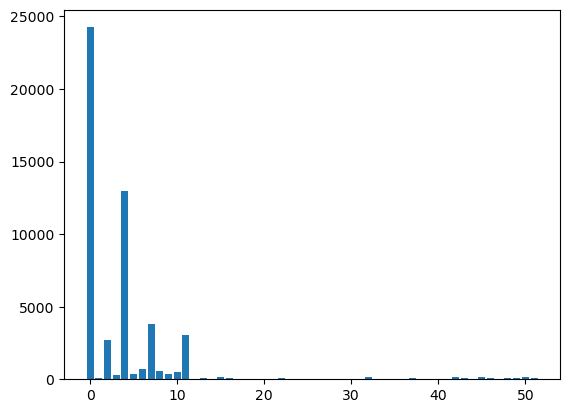

In [1669]:
X_feat, fs = chi_squared_feature_sel(x_enc, y_enc, 18)
print(X_feat)
num_samples, num_features = X_feat.shape
for i in range(len(fs.scores_)):
    print(i,'.',data.columns[i],':', fs.scores_[i])
print(sum(score > 100 for score in fs.scores_))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [1690]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


# Scale the data
scaler = MinMaxScaler()
X_feat = scaler.fit_transform(X_feat)  # Correct usage

# Assuming X_feat and y_enc are defined
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X_feat, y_enc, train_size=0.8, test_size=0.2, random_state=42)

# Flatten y to 1D
X_train = X_train_pd
X_test = X_test_pd
y_train = y_train_pd.ravel()
y_test = y_test_pd.ravel()

# Train the model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

# Print classification report
print(classification_report(y_test, y_pred))

# Output shapes for verification
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


0.7582377644968503
0.7401066063640769
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       171
           1       0.77      0.78      0.77      3332
           2       0.96      0.99      0.98       403
           3       0.70      0.52      0.60        63
           4       0.44      0.22      0.30        18
           5       0.65      0.64      0.64      2204

    accuracy                           0.74      6191
   macro avg       0.73      0.68      0.70      6191
weighted avg       0.74      0.74      0.74      6191

X_train shape: (24764, 18)
X_test shape: (6191, 18)


In [1671]:
# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

# Print classification report
print(classification_report(y_test, y_pred))

0.9997173316104022
0.7168470360200291
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       171
           1       0.74      0.77      0.75      3332
           2       0.96      0.99      0.97       403
           3       0.83      0.46      0.59        63
           4       0.57      0.44      0.50        18
           5       0.62      0.59      0.60      2204

    accuracy                           0.72      6191
   macro avg       0.77      0.70      0.72      6191
weighted avg       0.71      0.72      0.71      6191



In [1672]:
from sklearn.neural_network import MLPClassifier
# Train the model
model = MLPClassifier()
model.fit(X_train, y_train)

# Make predictions
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

0.7528266838959781
0.7346147633661767


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [1698]:
model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],          # Number of boosting stages
    'max_depth': [3, 5, 7],                  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],         # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV with the model, parameter grid, and number of cross-validations
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Fit GridSearchCV on your training data
grid_search.fit(X_train, y_train)  # Ensure X_train and y_train are your data
grid_search.score(X_test, y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END ..................n_estimators=100;, score=0.741 total time=  12.5s
[CV 1/3] END ..................n_estimators=100;, score=0.743 total time=  12.6s
[CV 2/3] END ..................n_estimators=100;, score=0.745 total time=  12.6s


0.7401066063640769

In [1689]:
grid_search.best_estimator_

GradientBoostingClassifier(max_depth=5, min_samples_leaf=4, n_estimators=50,
                           random_state=42)

In [1684]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameters and ranges you want to test
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2'],
}

# Set up GridSearchCV with the model, parameter grid, and number of cross-validations
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit GridSearchCV on your training data
grid_search.fit(X_train, y_train)  # Ensure X_train and y_train are your data
grid_search.score(X_test, y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.717 total time=   1.5s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.721 total time=   1.5s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.711 total time=   1.5s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.724 total time=   1.5s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.714 total time=   1.5s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.720 total time=   3.0s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;,

0.7391374575997416

In [1685]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [1680]:
# Define the model
mlp = MLPClassifier()

# Define the hyperparameters and ranges you want to test
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    # 'activation': ['tanh', 'relu'],
    # 'solver': ['sgd', 'adam'],
    # 'alpha': [0.0001, 0.001, 0.01],
    # 'learning_rate': ['constant', 'adaptive'],
    # 'max_iter': [200, 300]
}

# Set up GridSearchCV with the model, parameter grid, and number of cross-validations
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV on your training data
grid_search.fit(X_train, y_train)  # Ensure X_train and y_train are your data
grid_search.score(X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=   6.5s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   6.6s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   6.7s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   6.8s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=   6.9s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........................hidden_layer_sizes=(100,); total time=   9.3s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   9.4s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   9.4s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   9.8s
[CV] END ..........................hidden_layer_sizes=(100,); total time=  10.1s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ........................hidden_layer_sizes=(50, 50); total time=  12.9s
[CV] END ........................hidden_layer_sizes=(50, 50); total time=  13.1s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ........................hidden_layer_sizes=(50, 50); total time=  13.2s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ........................hidden_layer_sizes=(50, 50); total time=  13.0s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ........................hidden_layer_sizes=(50, 50); total time=  13.4s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .......................hidden_layer_sizes=(100, 50); total time=  18.3s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .......................hidden_layer_sizes=(100, 50); total time=  17.4s
[CV] END .......................hidden_layer_sizes=(100, 50); total time=  17.4s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .......................hidden_layer_sizes=(100, 50); total time=  17.0s
[CV] END .......................hidden_layer_sizes=(100, 50); total time=  17.3s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......................hidden_layer_sizes=(100, 100); total time=  23.0s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......................hidden_layer_sizes=(100, 100); total time=  22.5s
[CV] END ......................hidden_layer_sizes=(100, 100); total time=  22.2s
[CV] END ......................hidden_layer_sizes=(100, 100); total time=  19.8s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......................hidden_layer_sizes=(100, 100); total time=  19.4s


/opt/anaconda3/envs/csci4521/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7359069617186238

In [1681]:
grid_search.best_estimator_

MLPClassifier(hidden_layer_sizes=(50,))

In [1673]:
# param_values = {
#     'max_depth': [3, 5, 10, 20, 40, None],
#     'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
#     'n_estimators': [50, 100, 200, 300, 500],
#     'learning_rate': [0.1, 0.05, 0.01, 0.001],
# }


# gbm_optimal = GridSearchCV(GradientBoostingClassifier(), param_grid=param_values, scoring='accuracy', cv=5)
# gbm_optimal.fit(X_train, y_train)
# print(gbm_optimal.best_params_)
# gbm_optimal.score(X_test, y_test)

In [1674]:
# param_values = {
#     'max_depth': [3, 5, 10, 20, 40, None],
#     'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
#     'n_estimators': [50, 100, 200, 300, 500],
# }

# rand_forest_optimal = GridSearchCV(RandomForestClassifier(), param_grid=param_values, scoring='accuracy', cv=5)
# rand_forest_optimal.fit(X_train, y_train)
# print(rand_forest_optimal.best_params_)
# rand_forest_optimal.score(X_test, y_test)

In [1675]:
# param_values = [{
#     'n_estimators': [5,10,20,50,100,250,500,1000],
#     'learning_rate': [val / 10 for val in range (1,20,2)],
#     }]


# adaboost_optimal = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), param_grid=param_values, scoring='accuracy', cv=5)
# adaboost_optimal.fit(X_train, y_train)
# print(adaboost_optimal.best_params_)
# adaboost_optimal.score(X_test, y_test)

In [1676]:
# param_grid = {
#     'C': [0.01, 0.1, 1, 10],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'degree': [1, 2, 3, 4, 5],
# }

# svc_optimal = GridSearchCV(SVC(), param_grid=param_grid, scoring='accuracy', cv=5)
# svc_optimal.fit(X_train, y_train)
# print(svc_optimal.best_params_)
# svc_optimal.score(X_test, y_test)

In [1677]:
# param_values = [{
#     'weights': ['distance', 'uniform'],
#     'n_neighbors': [val for val in range(1,500,50)],
#     }]


# knn_optimal = GridSearchCV(KNeighborsClassifier(), param_grid=param_values, scoring='accuracy', cv=5)
# knn_optimal.fit(X_train, y_train)
# print(knn_optimal.best_params_)
# knn_optimal.score(X_train, y_train)
# knn_optimal.score(X_test, y_test)